In [2]:
!pip install arch


   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.2 kB ? eta -:--:--
   --------------------------------- ------ 786.4/926.2 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 926.2/926.2 kB 2.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch


In [4]:
df = pd.read_csv("C:\\Users\\sharo\\OneDrive\\Desktop\\3M Stock Price History.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [6]:
df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)


In [9]:
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
returns = df['Log_Returns'].dropna()


In [10]:
arch_test_result = het_arch(returns)
print(f"ARCH Test p-value: {arch_test_result[1]:.4f}")


ARCH Test p-value: 1.0000


In [11]:
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1582.50
Distribution:                  Normal   AIC:                          -3157.00
Method:            Maximum Likelihood   BIC:                          -3139.24
                                        No. Observations:                  625
Date:                Thu, Jul 24 2025   Df Residuals:                      624
Time:                        15:22:07   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.2016e-04  7.778e-04      1.054      0.292 

C:\Users\sharo\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003732. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [12]:
forecast = garch_fit.forecast(horizon=63)
forecast_variance = forecast.variance[-1:]  
forecast_volatility = np.sqrt(forecast_variance).T  
forecast_volatility.columns = ['Forecasted Daily Volatility']


In [13]:
annualized_vol = forecast_volatility * np.sqrt(252)  


In [14]:
print("\nForecasted Daily Volatility (next 63 days):")
print(forecast_volatility.head())

print("\nForecasted Annualized Volatility (next 3 months):")
print(annualized_vol.head())



Forecasted Daily Volatility (next 63 days):
      Forecasted Daily Volatility
h.01                     0.018663
h.02                     0.019063
h.03                     0.019234
h.04                     0.019307
h.05                     0.019339

Forecasted Annualized Volatility (next 3 months):
      Forecasted Daily Volatility
h.01                     0.296259
h.02                     0.302619
h.03                     0.305329
h.04                     0.306493
h.05                     0.306995


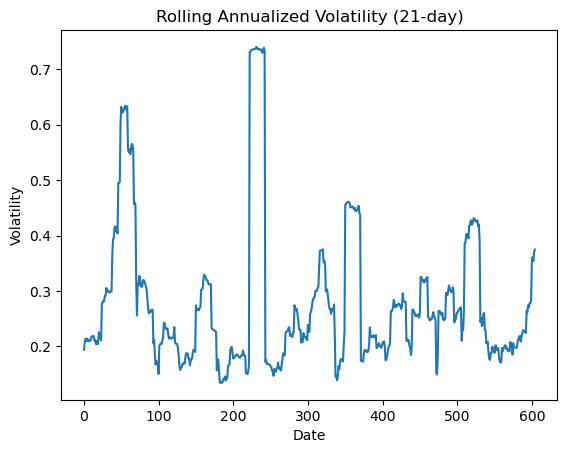

In [15]:
rolling_vol = returns.rolling(window=21).std() * np.sqrt(252)
rolling_vol.plot(title='Rolling Annualized Volatility (21-day)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()


In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint, kpss
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt

df = pd.read_excel("C:\\Users\\sharo\\OneDrive\\Desktop\\CMO-Historical-Data-Monthly (1).xlsx", sheet_name="Monthly Prices", skiprows=4)

df.head()


,Unnamed: 0,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
0,NaN,($/bbl),($/bbl),($/bbl),($/bbl),($/mt),($/mt),($/mmbtu),($/mmbtu),($/mmbtu),...,($/mt),($/dmtu),($/mt),($/mt),($/mt),($/mt),($/mt),($/troy oz),($/troy oz),($/troy oz)
1,NaN,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,...,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
2,1960M01,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,715.4,206.1,2180.4,1631,260.8,35.27,83.5,0.9137
3,1960M02,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,728.19,203.7,2180.4,1631,244.9,35.27,83.5,0.9137
4,1960M03,1.63,1.63,1.63,…,…,…,0.14,0.404774,…,...,511.471832,11.42,684.94,210.3,2173.8,1631,248.7,35.27,83.5,0.9137


In [18]:
print(df.columns.tolist())


['Date', 'Oil', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI', 'Coal, Australian', 'Coal, South African **', 'Natural gas, US', 'Natural gas, Europe', 'Liquefied natural gas, Japan', 'Natural gas index', 'Cocoa', 'Coffee, Arabica', 'Coffee, Robusta', 'Tea, avg 3 auctions', 'Tea, Colombo', 'Tea, Kolkata', 'Tea, Mombasa', 'Coconut oil', 'Groundnuts', 'Fish meal', 'Groundnut oil **', 'Palm oil', 'Palm kernel oil', 'Soybeans', 'Soybean oil', 'Soybean meal', 'Rapeseed oil', 'Sunflower oil', 'Barley', 'Maize', 'Sorghum', 'Rice, Thai 5% ', 'Rice, Thai 25% ', 'Rice, Thai A.1', 'Rice, Viet Namese 5%', 'Wheat, US SRW', 'Wheat, US HRW', 'Banana, Europe', 'Banana, US', 'Orange', 'Beef **', 'Chicken **', 'Lamb **', 'Shrimps, Mexican', 'Sugar, EU', 'Sugar, US', 'Sugar', 'Tobacco, US import u.v.', 'Logs, Cameroon', 'Logs, Malaysian', 'Sawnwood, Cameroon', 'Sawnwood, Malaysian', 'Plywood', 'Cotton, A Index', 'Rubber, TSR20 **', 'Rubber, RSS3', 'Phosphate rock', 'DAP', 'TSP', 'Urea ', 'Potas

In [19]:
df = df.rename(columns={
    'Unnamed: 0': 'Date',
    'Crude oil, average': 'Oil',
    'Sugar, world': 'Sugar',
    'Gold': 'Gold',
    'Silver': 'Silver',
    'Wheat, US SRW': 'Wheat',
    'Soybeans, US': 'Soybeans'
})

df = df[['Date', 'Oil', 'Sugar', 'Gold', 'Silver', 'Wheat', 'Soybeans']]


In [22]:
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%YM%m')

In [23]:
df = df[['Date', 'Oil', 'Sugar', 'Gold', 'Silver', 'Wheat', 'Soybeans']]

In [24]:
df.set_index('Date', inplace=True)

In [25]:
df.tail()

,Oil,Sugar,Gold,Silver,Wheat,Soybeans
Date,,,,,,
2025-02-01,73.819,0.422846,2894.73,32.152,243.50765,412.15
2025-03-01,70.701333,0.416453,2983.25,33.188,227.542525,401.11
2025-04-01,65.905,0.40102,3217.64,32.225,219.583846,407.6
2025-05-01,62.748667,0.389997,3309.49,32.763,221.270381,414.113636
2025-06-01,69.146667,0.368833,3352.66,36.005,217.305739,415.657333


In [28]:
df_cleaned = df.apply(pd.to_numeric, errors='coerce')
df_cleaned = df_cleaned.dropna()
df_cleaned.head()

,Oil,Sugar,Gold,Silver,Wheat,Soybeans
Date,,,,,,
1979-01-01,17.450,0.1669,227.28,6.2027,140.36,284.0
1979-02-01,20.750,0.1814,245.67,7.3494,144.77,298.0
1979-03-01,22.025,0.1865,242.05,7.4159,144.04,310.0
1979-04-01,22.425,0.1724,239.11,7.4371,142.20,300.0
1979-05-01,33.500,0.1731,257.59,8.3760,141.43,300.0


In [37]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

log_df = np.log(df_cleaned + 1e-10)  # Adding small constant to avoid log(0)
print(log_df.head())

                 Oil     Sugar      Gold    Silver     Wheat  Soybeans
Date                                                                  
1979-01-01  2.859340 -1.790360  5.426183  1.824985  4.944211  5.648974
1979-02-01  3.032546 -1.707051  5.503989  1.994619  4.975146  5.697093
1979-03-01  3.092178 -1.679324  5.489144  2.003626  4.970091  5.736572
1979-04-01  3.110176 -1.757938  5.476924  2.006481  4.957235  5.703782
1979-05-01  3.511545 -1.753886  5.551369  2.125370  4.951805  5.703782


In [38]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] < 0.05 

In [39]:
stationary_results = {}
for col in log_df.columns:
    print(f"\nChecking stationarity for {col}:")
    stationary_results[col] = check_stationarity(log_df[col])


Checking stationarity for Oil:
ADF Statistic: -1.9160697101946897
p-value: 0.32453958312185094
Critical Values:
   1%: -3.442339408568417
   5%: -2.866828612425054
   10%: -2.5695866531248335

Checking stationarity for Sugar:
ADF Statistic: -2.62186245869241
p-value: 0.08856239932405513
Critical Values:
   1%: -3.442339408568417
   5%: -2.866828612425054
   10%: -2.5695866531248335

Checking stationarity for Gold:
ADF Statistic: 0.2020916208132485
p-value: 0.9723786628731683
Critical Values:
   1%: -3.442450336733213
   5%: -2.8668774460774498
   10%: -2.5696126760816553

Checking stationarity for Silver:
ADF Statistic: -0.8711654976391879
p-value: 0.7973196924761363
Critical Values:
   1%: -3.442450336733213
   5%: -2.8668774460774498
   10%: -2.5696126760816553

Checking stationarity for Wheat:
ADF Statistic: -2.063225178962882
p-value: 0.259556629773533
Critical Values:
   1%: -3.442495284887805
   5%: -2.86689723299801
   10%: -2.5696232204003677

Checking stationarity for Soybean

In [40]:
if not all(stationary_results.values()):
    print("\nSome series are non-stationary - applying differencing")
    diff_df = log_df.diff().dropna()
    for col in diff_df.columns:
        print(f"\nChecking differenced {col}:")
        check_stationarity(diff_df[col])
else:
    diff_df = log_df.copy()


Some series are non-stationary - applying differencing

Checking differenced Oil:
ADF Statistic: -11.03390304389608
p-value: 5.579175057394083e-20
Critical Values:
   1%: -3.4424279871882573
   5%: -2.8668676073304407
   10%: -2.569607433093642

Checking differenced Sugar:
ADF Statistic: -15.801417001209844
p-value: 1.0729349833575342e-28
Critical Values:
   1%: -3.442339408568417
   5%: -2.866828612425054
   10%: -2.5695866531248335

Checking differenced Gold:
ADF Statistic: -7.105643160874752
p-value: 4.0604878829605607e-10
Critical Values:
   1%: -3.442450336733213
   5%: -2.8668774460774498
   10%: -2.5696126760816553

Checking differenced Silver:
ADF Statistic: -16.486034305808644
p-value: 2.2145414270457284e-29
Critical Values:
   1%: -3.442339408568417
   5%: -2.866828612425054
   10%: -2.5695866531248335

Checking differenced Wheat:
ADF Statistic: -8.814922869373927
p-value: 1.9459598616675077e-14
Critical Values:
   1%: -3.442495284887805
   5%: -2.86689723299801
   10%: -2.5

In [43]:
var_model = VAR(diff_df)
results = var_model.fit(maxlags=12, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Jul, 2025
Time:                     16:30:54
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -33.1000
Nobs:                     548.000    HQIC:                  -33.4733
Log likelihood:           4649.86    FPE:                2.28403e-15
AIC:                     -33.7129    Det(Omega_mle):     1.98431e-15
--------------------------------------------------------------------
Results for equation Oil
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.002433         0.003748            0.649           0.516
L1.Oil              0.306077         0.043682            7.007           0.000
L1.Sugar            0.046937         0.045655            1.028        

C:\Users\sharo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
coint_test = coint(log_df['Oil'], log_df['Gold']) 
print(f"\nCointegration test p-value: {coint_test[1]}")


Cointegration test p-value: 0.04394113698264887


In [45]:
if coint_test[1] < 0.05:  # If cointegrated
    vecm_model = VECM(log_df, deterministic="ci", k_ar_diff=2)
    vecm_results = vecm_model.fit()
    print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Oil
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Oil          0.3065      0.043      7.094      0.000       0.222       0.391
L1.Sugar        0.0466      0.045      1.033      0.302      -0.042       0.135
L1.Gold        -0.0273      0.132     -0.207      0.836      -0.286       0.231
L1.Silver       0.0434      0.075      0.576      0.564      -0.104       0.191
L1.Wheat       -0.0614      0.063     -0.975      0.329      -0.185       0.062
L1.Soybeans     0.0486      0.080      0.611      0.541      -0.107       0.205
L2.Oil         -0.1148      0.043     -2.667      0.008      -0.199      -0.030
L2.Sugar       -0.0799      0.045     -1.774      0.076      -0.168       0.008
L2.Gold        -0.2062      0.133     -1.555      0.120      -0.466       0.054
L2.Silver       0.1330      0.075    

C:\Users\sharo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
